# Corona weather analyses
Roald Ruiter, 29 March

## Abstract
Earlier [research](https://www.nature.com/articles/418601a) suggested that heavily reduced air traffic over the US after 9/11 caused larger differences between daily minimum and maximum temperatures. Here I do a similar analyses for the weather over the Netherlands. I do not find a significantly higher temperature difference as compared to historical data. However, looking at the number of sun hours there was no period in the last 70 years which had a comparable number of sun hours. In the period from 21-28 March the average was 11.2 hours.

## Introduction
I noticed that it was very sunny in the Netherlands recently. Then I remembered a [study](https://www.nature.com/articles/418601a) from 2002 where they did a weather analyses of US weather around 9/11. The authors found a significantly larger difference between the daily maximum and minimum temperatures during the three days of heavily reduced air traffic above the US. The effect was partially attributed to a reduction in [contrails](https://en.wikipedia.org/wiki/Contrail). 

## Methods
For the analyses here I pull data from the [API](https://www.knmi.nl/kennis-en-datacentrum/achtergrond/data-ophalen-vanuit-een-script) of the Royal Dutch Meteorology Institute ([KNMI](https://www.knmi.nl/nederland-nu/klimatologie/daggegevens)). Weather data is measured at up to 50 different stations in the period from 1950 to 2020. I averaged the data for all weather stations. The plots show data which has been averaged over a seven day period. The three days before and after a specific data are included in the average.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
from altair import datum
import requests
from io import StringIO

alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [2]:
# Get data from KNMI api
payload = {'vars': 'TG:TN:TX:SQ:Q', 'start': '19500101'}
knmi_api_url = 'http://projects.knmi.nl/klimatologie/daggegevens/getdata_dag.cgi'
r = requests.get(knmi_api_url, params=payload)
data_text = r.text

In [3]:
data = StringIO(data_text)
knmi_data = pd.read_csv(data,
    sep=",",
    comment="#",
    header=None, 
    names="""\
station,date,avg_temp,\
min_temp,\
max_temp,\
sun_h,\
glob_rad""".split(","),
    na_values='     ',
)

In [4]:
# Do some data clean-up, formatting and transformations
knmi_data['date'] = pd.to_datetime(knmi_data["date"], format='%Y%m%d')
knmi_data[[col for col in knmi_data if "temp" in col or 'sun' in col]] /= 10
cols_to_look_for_nas = list(knmi_data)[2:]
knmi_data.dropna(subset=cols_to_look_for_nas, how='all', inplace=True)
knmi_data = knmi_data.groupby('date').mean()
knmi_data.drop(columns='station', inplace=True)
knmi_data['delta_temp'] = knmi_data['max_temp'] - knmi_data['min_temp']

knmi_data.tail()

,avg_temp,min_temp,max_temp,sun_h,glob_rad,delta_temp
date,,,,,,
2020-03-24,5.344118,-0.752941,11.155882,11.246875,1789.78125,11.908824
2020-03-25,5.720588,-1.167647,11.750000,11.453125,1838.37500,12.917647
2020-03-26,5.850000,-0.100000,11.100000,11.571875,1804.09375,11.200000
2020-03-27,7.847059,1.761765,13.929412,11.340625,1694.90625,12.167647
2020-03-28,7.300000,3.732353,11.876471,10.753125,1707.37500,8.144118


## Results
First I do a similar analyses which was done in the [2002](https://www.nature.com/articles/418601a) study. Below I show the difference between the daily maximum and minimum temperature from 1950 until today. Although an increase in the temperature difference can be seen in the 2020 data, starting from mid-March, it is not significantly higher then many other years. Even if we reduce the sample period to the last 20 years (which probably had comparable air traffic), there are a few years which have much higher temperature differences.

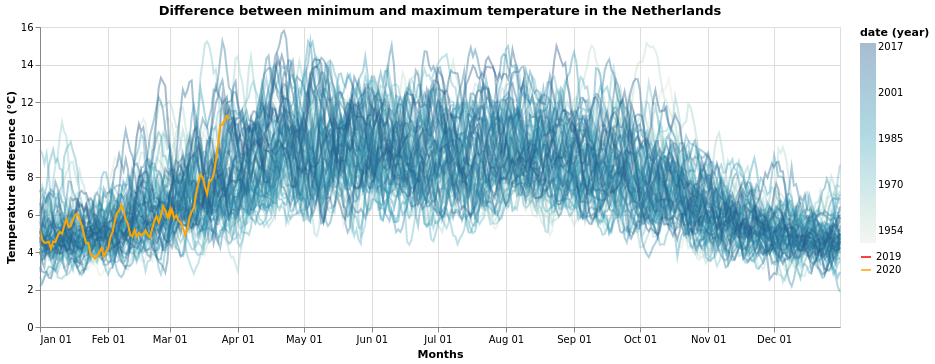

In [5]:
knmi_data_before_2020 = knmi_data[knmi_data.index < '2020-01-01']
knmi_data_2020 = knmi_data[knmi_data.index >= '2020-01-01']

to_plot = "delta_temp"
rolling_mean_frame = [-3, 3]

base = alt.Chart(knmi_data_2020.reset_index())
line_2020 = base.mark_line(color='orange').encode(
    x='monthdate(date):T',
    y="rolling_mean:Q",
    color=alt.Color(
        'year(date):N', 
        title='', 
        scale=alt.Scale(
            domain=['2019', '2020'],
            range=['red', 'orange']
            )
        )
).transform_window(
    rolling_mean=f'mean({to_plot})',
    frame=rolling_mean_frame
);

base_old = alt.Chart(knmi_data_before_2020.reset_index())
line_old = base_old.mark_line(opacity=0.4).encode(
    alt.X('monthdate(date):T', title='Months'),
    alt.Y("rolling_mean:Q", title="Temperature difference (°C)"),
    color=alt.Color('year(date):Q', scale=alt.Scale(scheme="lighttealblue")),
).transform_window(
    rolling_mean=f'mean({to_plot})',
    frame=rolling_mean_frame
);

(line_old + line_2020).properties(
    width=800,
    title='Difference between minimum and maximum temperature in the Netherlands'
)

However, if I look at the number of daily sun hours, 2020 really is an outlier. The next highest in the same date range, is almost an hour shorter and does not last as long as the 2020 run.

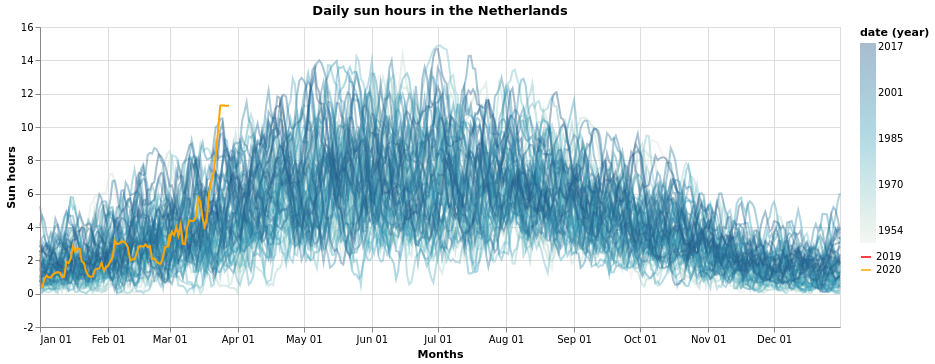

In [6]:
to_plot = "sun_h"

base = alt.Chart(knmi_data_2020.reset_index())
line_2020 = base.mark_line(color='orange').encode(
    x='monthdate(date):T',
    y="rolling_mean:Q",
    color=alt.Color(
        'year(date):N', 
        title='', 
        scale=alt.Scale(
            domain=['2019', '2020'],
            range=['red', 'orange']
            )
        )
).transform_window(
    rolling_mean=f'mean({to_plot})',
    frame=rolling_mean_frame
);

base_old = alt.Chart(knmi_data_before_2020.reset_index())
line_old = base_old.mark_line(opacity=0.4).encode(
    alt.X('monthdate(date):T', title='Months'),
    alt.Y("rolling_mean:Q", title="Sun hours"),
    color=alt.Color('year(date):Q', scale=alt.Scale(scheme="lighttealblue")),
).transform_window(
    rolling_mean=f'mean({to_plot})',
    frame=rolling_mean_frame
);

(line_old + line_2020).properties(
    width=800,
    title='Daily sun hours in the Netherlands'
)

## Conclusions
I'm no expert, so I'm not sure what the results say and if this is compelling evidence for contrail effects on the weather. If there was a clear relationship I would have expected the effect to become larger with time, since air traffic increased quite a bit from 1950 till now.